In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
records_long = []
records_wide = []
n = 0
for line in open('../serial_dump_from_daisy.txt', 'r'):
    try:
        if line.startswith('b'): 
            cv = float(line.split(" ")[2])
        else:
            in_v, out_v = map(float, line.split(" "))
            records_long.append((n, 'cv', cv))
            records_long.append((n, 'in_v', in_v))
            records_long.append((n, 'out_v', out_v))
            records_wide.append((n, cv, in_v, out_v))
            n += 1
    except Exception as e:
        print(f"? [{line.strip()}] ({str(e)})")
df_long = pd.DataFrame(records_long, columns=['n', 'name', 'val'])
df_wide = pd.DataFrame(records_wide, columns=['n', 'cv', 'in_v', 'out_v'])

<Axes: xlabel='n', ylabel='cv'>

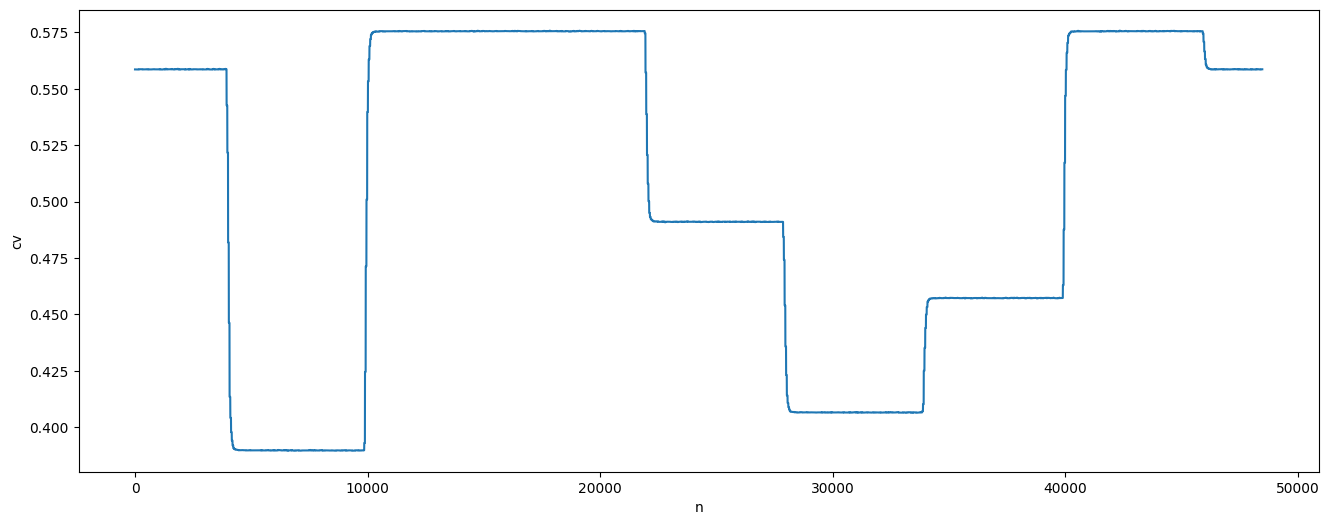

In [4]:
plt.figure(figsize=(16, 6))
sns.lineplot(df_wide, x='n', y='cv')

/tmp/ipykernel_27413/2726709270.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_long[11000:13000][df_long['name']=='cv'], x='n', y='val')


<Axes: xlabel='n', ylabel='val'>

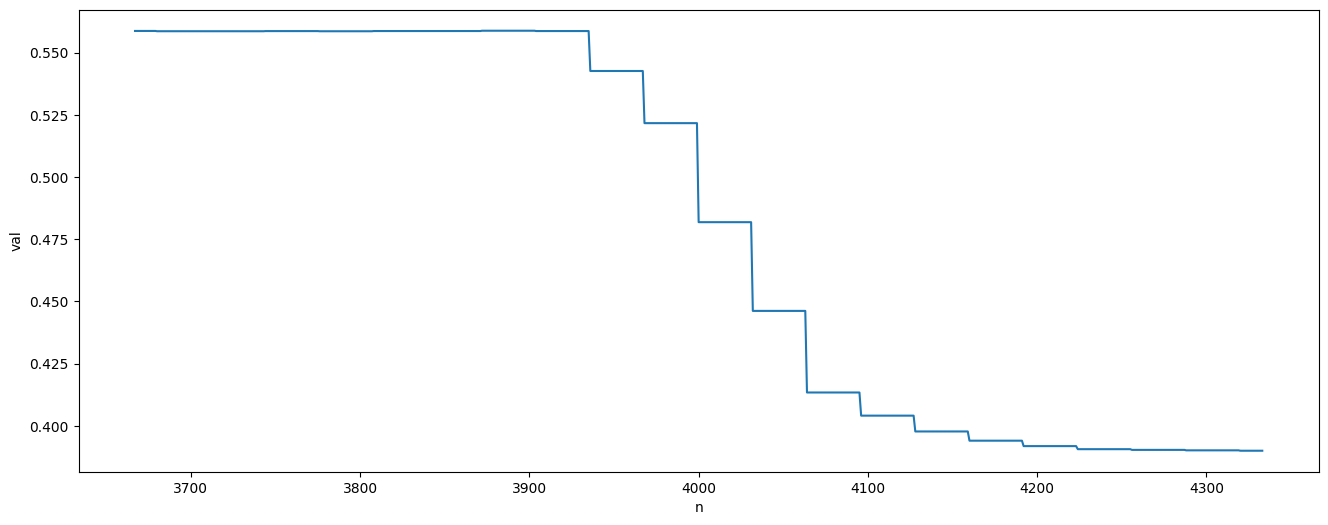

In [5]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=df_long[11000:13000][df_long['name']=='cv'], x='n', y='val')

<Axes: xlabel='n', ylabel='val'>

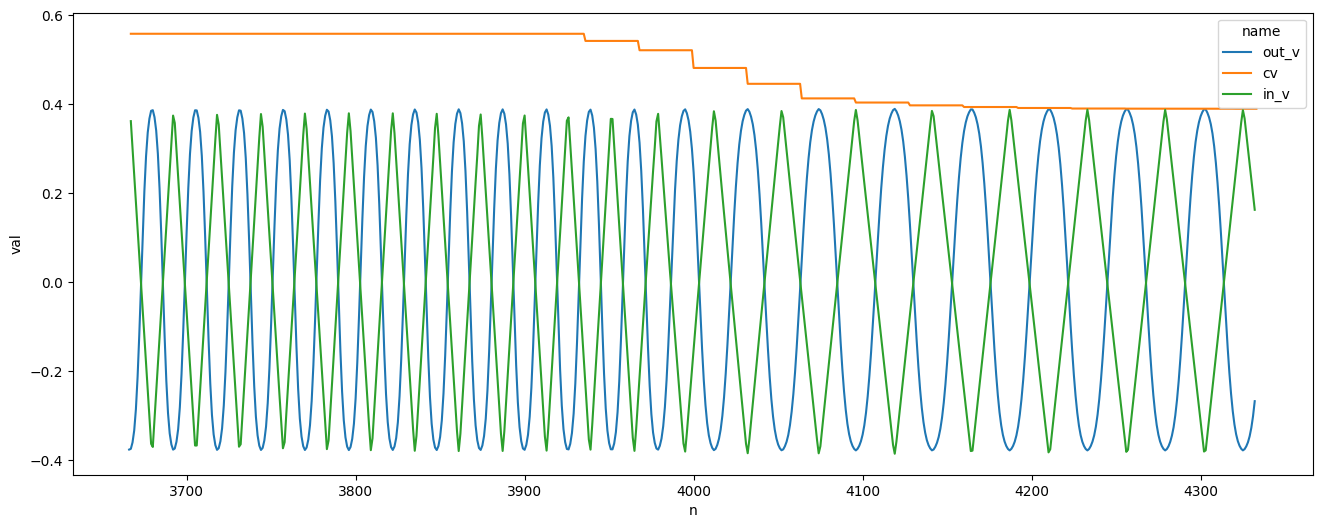

In [6]:
plt.figure(figsize=(16, 6))
sns.lineplot(df_long[11000:13000], x='n', y='val', hue='name')

In [7]:
df_long.head()

,n,name,val
0,0,cv,0.558590
1,0,in_v,-0.317861
2,0,out_v,0.373839
3,1,cv,0.558590
4,1,in_v,-0.256649


In [8]:
df_wide.head()

,n,cv,in_v,out_v
0,0,0.55859,-0.317861,0.373839
1,1,0.55859,-0.256649,0.345888
2,2,0.55859,-0.193586,0.296658
3,3,0.55859,-0.131589,0.221585
4,4,0.55859,-0.069552,0.122621


In [9]:
cvs = np.array(df_wide['cv'])
in_vs = np.array(df_wide['in_v'])
x = np.stack([cvs, in_vs]).transpose()

y_true = np.expand_dims(np.array(df_wide['out_v']), -1)

split = int(len(x) * 0.8)

print(split, cvs.shape, in_vs.shape, x.shape)

38787 (48484,) (48484,) (48484, 2)


In [10]:
train_x, train_y = x[:split], y_true[:split]
test_x, test_y = x[split:], y_true[split:]

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(38787, 2) (38787, 1) (9697, 2) (9697, 1)


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

TRAIN_SEQ_LEN = 20
TEST_SEQ_LEN = 9   # this comes from the model; kernel_size=3 and 2 dilations...


2023-09-03 13:41:39.294301: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-03 13:41:39.743713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
# fully dilated for training and strided for equiavlence testing

def create_dilated_model(seq_len, all_outputs=False):
    inp = Input((seq_len, 2))
    c1_output = Conv1D(name='c1', filters=4, kernel_size=3, dilation_rate=1, 
                       padding='causal', activation='relu')(inp)
    c2_output = Conv1D(name='c2', filters=8, kernel_size=3, dilation_rate=3, 
                       padding='causal')(c1_output)
    y_pred = Dense(name='d', units=1, activation=None)(c2_output)
    
    if all_outputs:
        model = Model(inp, [c1_output, c2_output, y_pred])
    else:
        model = Model(inp, y_pred)        
    print(model.summary())
    return model

# for testing ( i.e. getting only last of sequence )

def create_strided_model(seq_len, all_outputs=False):
    inp = Input((seq_len, 2))
    c1_output = Conv1D(name='c1', filters=4, kernel_size=3, strides=3, 
                       activation='relu')(inp)
    c2_output = Conv1D(name='c2', filters=8, kernel_size=3, strides=3)(c1_output)
    c2_output = Flatten()(c2_output)
    y_pred = Dense(name='d', units=1, activation=None)(c2_output)
    
    if all_outputs:
        model = Model(inp, [c1_output, c2_output, y_pred])
    else:
        model = Model(inp, y_pred)
    print(model.summary())
    return model

In [13]:
from tensorflow.keras.optimizers import Adam

train_model = create_dilated_model(TRAIN_SEQ_LEN, all_outputs=False)
test_model = create_dilated_model(TEST_SEQ_LEN, all_outputs=True)

# even though the model is untrained try this now to ensure
# that the weights are equivalent
test_model.set_weights(train_model.get_weights())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 2)]           0         
                                                                 
 c1 (Conv1D)                 (None, 20, 4)             28        
                                                                 
 c2 (Conv1D)                 (None, 20, 8)             104       
                                                                 
 d (Dense)                   (None, 20, 1)             9         
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 9, 2

2023-09-03 13:41:40.869857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-03 13:41:40.891396: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [129]:
def gen():
    for i in range(len(train_x)-TRAIN_SEQ_LEN-1):
        x = train_x[i:i+TRAIN_SEQ_LEN]
        y = train_y[i+1:i+1+TRAIN_SEQ_LEN]
        yield x, y  # (S, 2) & (S, 1)
                 
ds = tf.data.Dataset.from_generator(gen, 
    output_signature=(tf.TensorSpec(shape=(TRAIN_SEQ_LEN, 2), dtype=tf.float32),
                      tf.TensorSpec(shape=(TRAIN_SEQ_LEN, 1), dtype=tf.float32)))
ds = ds.cache().shuffle(1000).batch(32)
train_model.compile(Adam(1e-4), loss='mse')
train_model.fit(ds, epochs=10)


Epoch 1/10


2023-09-02 21:46:35.405004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-09-02 21:46:35.405165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1212/1212 [==============================] - 3s 2ms/step - loss: 0.0026
Epoch 2/10
1212/1212 [==============================] - 1s 966us/step - loss: 0.0023
Epoch 3/10
1212/1212 [==============================] - 1s 976us/step - loss: 0.0021
Epoch 4/10
1212/1212 [==============================] - 1s 981us/step - loss: 0.0020
Epoch 5/10
1212/1212 [==============================] - 1s 978us/step - loss: 0.0019
Epoch 6/10
1212/1212 [==============================] - 1s 968us/step - loss: 0.0018
Epoch 7/10
1212/1212 [==============================] - 1s 972us/step - loss: 0.0017
Epoch 8/10
1212/1212 [==============================] - 1s 975us/step - loss: 0.0017
Epoch 9/10
1212/1212 [==============================] - 1s 957us/step - loss: 0.0016
Epoch 10/10
1212/1212 [==============================] - 1s 961us/step - loss: 0.0016


In [130]:
test_model.set_weights(train_model.get_weights())

In [131]:
for w in train_model.weights:
    print(w.name, w.shape)
    

c1/kernel:0 (3, 2, 4)
c1/bias:0 (4,)
c2/kernel:0 (3, 4, 8)
c2/bias:0 (8,)
d/kernel:0 (8, 1)
d/bias:0 (1,)


In [132]:
test_seq = np.expand_dims(test_x[10:10+TEST_SEQ_LEN], 0)
test_seq.shape, test_seq

((1, 9, 2),
 array([[[ 0.4571022, -0.1536241],
         [ 0.4571022, -0.1103819],
         [ 0.4571022, -0.0658367],
         [ 0.4571022, -0.0220594],
         [ 0.4571022,  0.0226333],
         [ 0.4571022,  0.066679 ],
         [ 0.4571022,  0.1112678],
         [ 0.4571022,  0.1550736],
         [ 0.4571022,  0.1999679]]]))

In [133]:
# test_seq[0,3:6,:] = test_seq[0,0:3,:]
# test_seq[0,6:9,:] = test_seq[0,0:3,:]

# test_seq

In [134]:
yp = test_model(test_seq)
yp

[<tf.Tensor: shape=(1, 9, 4), dtype=float32, numpy=
 array([[[0.00000000e+00, 3.24718714e-01, 0.00000000e+00, 1.83049440e-01],
         [0.00000000e+00, 1.84939474e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.76227018e-01, 0.00000000e+00, 1.20036930e-01],
         [0.00000000e+00, 1.41048133e-01, 0.00000000e+00, 1.73484296e-01],
         [0.00000000e+00, 1.05749965e-01, 0.00000000e+00, 2.27344319e-01],
         [0.00000000e+00, 7.04685003e-02, 0.00000000e+00, 2.81039983e-01],
         [0.00000000e+00, 3.52130346e-02, 0.00000000e+00, 3.34890038e-01],
         [0.00000000e+00, 2.24668533e-04, 0.00000000e+00, 3.88289928e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.42345142e-01]]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 9, 8), dtype=float32, numpy=
 array([[[ 0.06104647,  0.10225609, -0.00442015, -0.11415084,
           0.02697212,  0.12748821, -0.09461704, -0.00032156],
         [ 0.06122325,  0.02759404,  0.02732116, -0.0786686 ,
        

<Axes: >

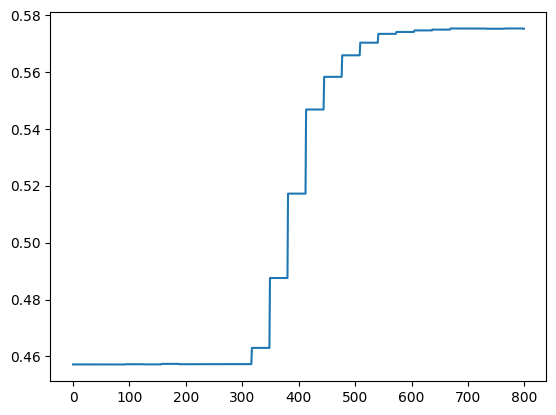

In [135]:
# plot test_x looking for a jump in CV we can zoom in on for seeing
# frequency change
#sns.lineplot(test_x[2100:2700,0])
sns.lineplot(test_x[800:1600,0])

In [136]:
test_records = []

for i in range(800, 1600):
    test_seq = np.expand_dims(test_x[i:i+TEST_SEQ_LEN], 0)
    
    y_true = float(test_y[i+TEST_SEQ_LEN])
    
    # dilated version
#    _c1o, _c2o, y_pred_v1 = test_model(test_seq)
#    y_pred_v1 = float(y_pred_v1[:,-1,:])
    
    # version with strided
    y_pred_and_intermediate_layer = test_model(test_seq)
    y_pred = y_pred_and_intermediate_layer[-1]    
    y_pred = y_pred.numpy().flatten()[-1]  # last element of sequence
    y_pred = float(y_pred)
    
    test_records.append((i, 'y_true', y_true))    
    test_records.append((i, 'y_pred', y_pred))
    #test_records.append((i, 'y_pred_saa', y_pred_stand_alone_app[i]))    
    
test_df = pd.DataFrame(test_records, columns=['n', 'name', 'value'])

<Axes: xlabel='n', ylabel='value'>

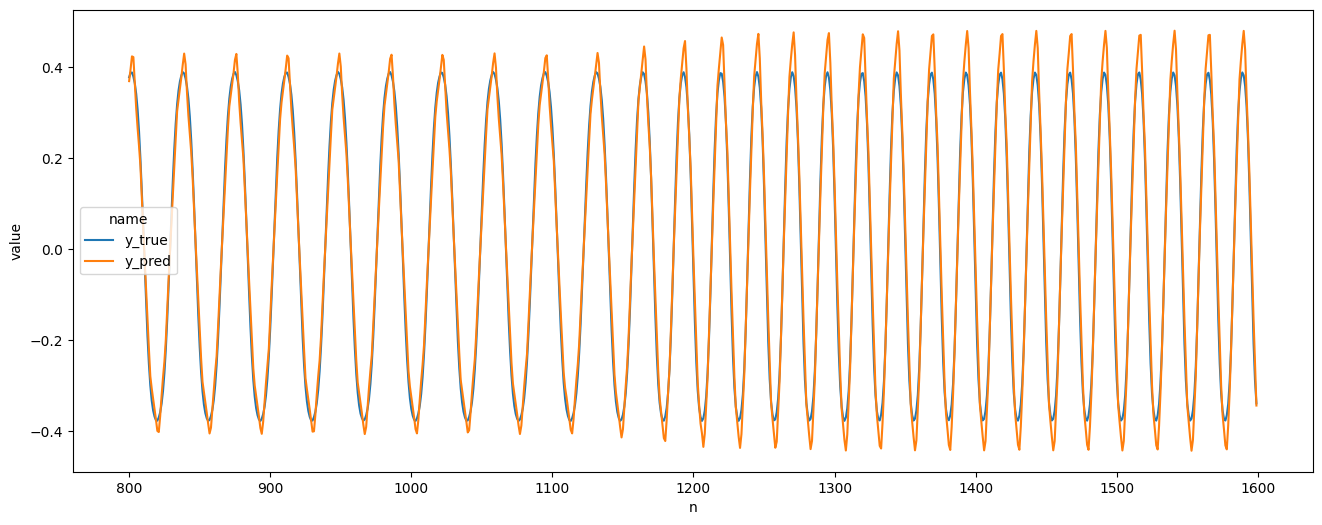

In [137]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=test_df, x='n', y='value', hue='name')

generate assets for deploy
* saved_model, which will need to be zipped
* quantisation_data.npy

In [26]:
test_model_v2.save("saved_model/")

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [27]:
# sample N examples from training data for quantisation 

quantisation_data = []
idxs = list(range(len(train_x)))
random.shuffle(idxs)
for i in idxs[:400]:
    quantisation_data.append(train_x[i:i+TEST_SEQ_LEN])
quantisation_data = np.stack(quantisation_data).astype(np.float32)
print("quantisation_data", quantisation_data.shape)
np.save("quantisation_data.npy", quantisation_data)

quantisation_data (400, 9, 2)


also generate some test features for checking inference

In [28]:
with open("test_features.txt", "w") as f:
    for feature in test_x.flatten():
        #print(feature)
        print(feature, file=f)

# now deploy to EI

and run inference to collect results from above test_features.txt

`./build/app > /tmp/y_pred.stand_alone_app.txt`

and reread back in to ply vs y_true

<Axes: xlabel='n', ylabel='value'>

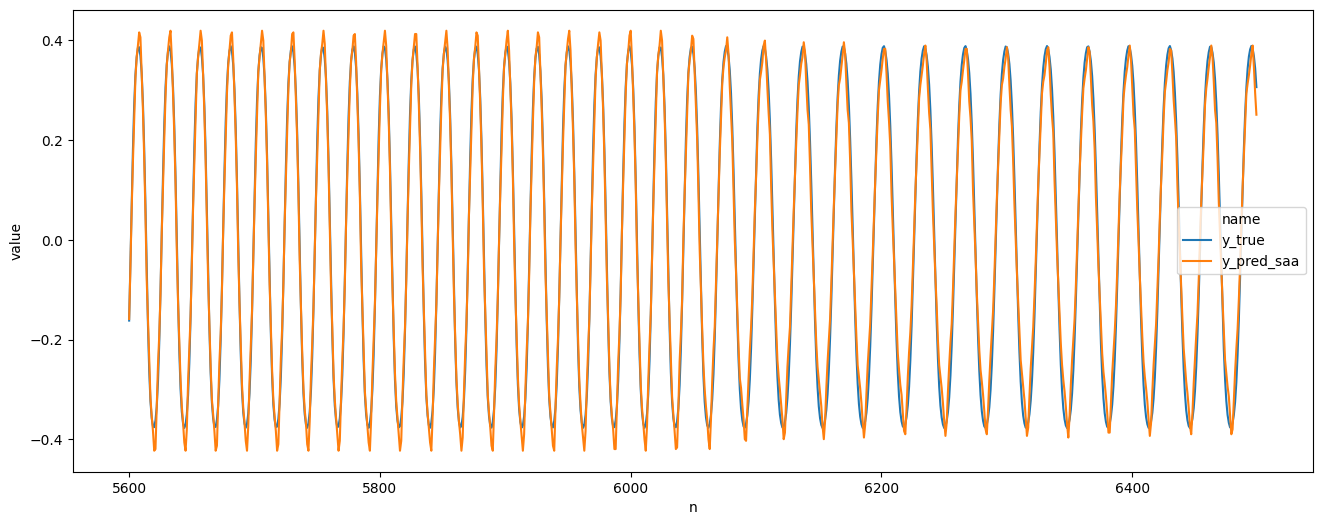

In [79]:
y_pred_stand_alone_app = list(map(float, open('/tmp/y_pred.stand_alone_app.txt').readlines()))

test_records = []
for i in range(5600, 6500):
    y_true = float(test_y[i+TEST_SEQ_LEN])
    test_records.append((i, 'y_true', y_true))
    test_records.append((i, 'y_pred_saa', y_pred_stand_alone_app[i]))    
test_df = pd.DataFrame(test_records, columns=['n', 'name', 'value'])

plt.figure(figsize=(16, 6))
sns.lineplot(data=test_df, x='n', y='value', hue='name')